In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.model_selection import cross_validate

warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
scope_data = pd.read_csv("scope_data.csv")

In [3]:
scope_data = scope_data.dropna()

In [4]:
scope_data.shape

(1791, 12)

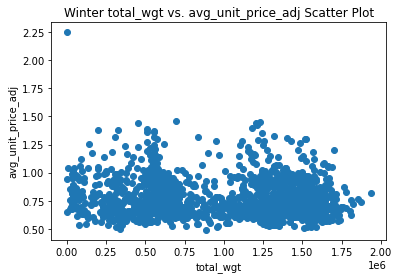

In [5]:
plt.scatter(scope_data["total_wgt"], scope_data["avg_unit_price_adj"])
plt.xlabel("total_wgt")
plt.ylabel("avg_unit_price_adj")
plt.title("Winter total_wgt vs. avg_unit_price_adj Scatter Plot")
plt.show()

In [6]:
scope_data.avg_unit_price_adj.max()

2.245780916

In [7]:
d = scope_data["avg_unit_price_adj"].describe()
d

count    1791.000000
mean        0.775227
std         0.160662
min         0.491980
25%         0.660999
50%         0.740019
75%         0.857930
max         2.245781
Name: avg_unit_price_adj, dtype: float64

In [8]:
IQR = d["75%"] - d["25%"]

In [9]:
lower_limit =d["25%"] -  IQR*1.5

In [10]:
upper_limit =d["75%"] +  IQR*1.5

In [11]:
upper_limit

1.153326115

In [12]:
upper_limit -  scope_data["avg_unit_price"].max()

-4.430381434999999

In [13]:
remove = scope_data["avg_unit_price_adj"].between(lower_limit,upper_limit).sum()
remove

1733

In [14]:
scope_data.shape[0] - remove

58

In [15]:
scope_data = scope_data[scope_data["avg_unit_price_adj"].between(lower_limit,upper_limit )]

In [16]:
scope_data.shape

(1733, 12)

In [17]:
d = scope_data["avg_unit_price_adj"].describe()
d

count    1733.000000
mean        0.757965
std         0.129128
min         0.491980
25%         0.659185
50%         0.735588
75%         0.840514
max         1.152588
Name: avg_unit_price_adj, dtype: float64

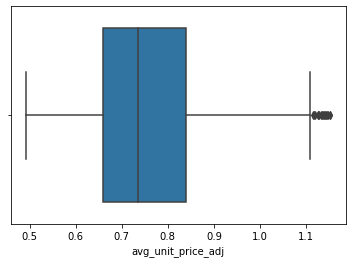

In [18]:
sns.boxplot(scope_data["avg_unit_price_adj"])
plt.show()

In [19]:
def season(month):
    if month in (3, 4, 5):
        return "Spring"
    elif month in (6,7,8):
        return "Summer"
    elif month in (9,10,11):
        return "Fall"
    else:
        return "Winter"

In [20]:
scope_data['season'] = scope_data["month"].apply(season)

In [21]:
scope_data.head(5)

,fisc_wk_strt_dt,month,year,week_of_month,mkt_lvl,value,total_wgt,total_sales,avg_unit_price,avg_unit_price_adj,log_price,log_units,season
0,5/5/2013,5,2013,18,North,236.526,1642565.196,3474335.31,2.115189,0.894273,-0.111744,14.311770,Spring
1,5/5/2013,5,2013,18,South,236.526,1422200.660,2850561.14,2.004331,0.847404,-0.165578,14.167716,Spring
2,5/5/2013,5,2013,18,West,236.526,694843.260,1440919.45,2.073733,0.876746,-0.131538,13.451442,Spring
3,5/12/2013,5,2013,19,North,236.526,1587125.754,3533834.04,2.226562,0.941360,-0.060429,14.277435,Spring
4,5/12/2013,5,2013,19,South,236.526,1376157.075,2888754.41,2.099146,0.887491,-0.119357,14.134805,Spring


In [22]:
def fit_ridge_tidymodels(data):
    
    # Prepare the data
    X = data[['log_price', 'month', 'week_of_month', 'year']]
    y = data['log_units']
    
    # Define pipeline for the model
 
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, X.columns)
        ])
    

    ridge_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('ridge', Ridge())
    ])
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'ridge__alpha': np.logspace(-6, -1, num=20),
    }
    
    # Create a 10-fold cross-validation object
    sales_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Perform cross-validated grid search
    grid_search = GridSearchCV(
        ridge_model, 
        param_grid=param_grid, 
        cv=sales_cv, 
        scoring={
            'rmse': make_scorer(mean_squared_error, squared=False),
            'r2': make_scorer(r2_score)
        },
        refit='rmse'
    )
    
    # Fit the model
    grid_search.fit(X, y,)
    
    # Extract the best model
    best_model = grid_search.best_estimator_
    
    # Fit the best model on the whole dataset
    best_model.fit(X, y)
    
    # Extract the log_price coefficient
    coefficients = pd.DataFrame(best_model.named_steps['ridge'].coef_, index=X.columns, columns=['estimate'])
    normalized_stats = pd.DataFrame(best_model.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler'].var_, index=X.columns[:4], columns=['sd'])
    coefs_denormalized = coefficients.join(normalized_stats)
    coefs_denormalized['beta_denormalized'] = coefs_denormalized['estimate'] / coefs_denormalized['sd']
    log_price_beta = coefs_denormalized.loc['log_price', 'beta_denormalized']
    
    predict = best_model.predict(X)
    mse = mean_squared_error(y, predict)
    rmse = np.sqrt(mse)
    
    result = {'price_elasticity': log_price_beta, "rmse":rmse}
    
    return result


In [23]:
combined_data_ridge = pd.DataFrame()

seasons = scope_data["season"].unique()

for s in seasons:
    season_df = scope_data[scope_data["season"] == s]
    df= season_df.groupby("mkt_lvl").apply(lambda x : pd.DataFrame({'data': [x]})).reset_index().drop(columns=['level_1'])
    applied = df["data"].apply(fit_ridge_tidymodels)
    for i, j in zip(df["mkt_lvl"], applied):
        j["mkt_lvl"] = i
        j["season"] = s
         
    for i in applied:
        dictionary = {"Season":i["season"], "mkt_lvl": i["mkt_lvl"], 
                              "Ridge_elast":i['price_elasticity'],
                             "Ridge_rmse":i['rmse']}
        combined_data_ridge = combined_data_ridge.append(dictionary, ignore_index=True)
        

In [24]:
combined_data_ridge

,Season,mkt_lvl,Ridge_elast,Ridge_rmse
0,Spring,North,-6.182509,0.673257
1,Spring,South,1.684183,1.005754
2,Spring,West,1.589772,0.541335
3,Summer,North,-3.509073,0.643131
4,Summer,South,-0.564104,0.558167
5,Summer,West,1.049147,0.521536
6,Fall,North,-2.734128,0.612589
7,Fall,South,-2.004981,0.525894
8,Fall,West,-0.111746,0.512502
9,Winter,North,-9.549992,0.742841


In [25]:
def fit_lasso_tidymodels(data):
    
    # Prepare the data
    X = data[['log_price', 'month', 'week_of_month', 'year']]
    y = data['log_units']
    
    # Define pipeline for the model
 
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, X.columns)
        ])
    

    lasso_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('lasso', Lasso())
    ])
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'lasso__alpha': np.logspace(-6, -1, num=20), "lasso__max_iter":[5000] }
    
    # Create a 10-fold cross-validation object
    sales_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Perform cross-validated grid search
    grid_search = GridSearchCV(
        lasso_model, 
        param_grid=param_grid, 
        cv=sales_cv, 
        scoring={
            'rmse': make_scorer(mean_squared_error, squared=False),
            'r2': make_scorer(r2_score)
        },
        refit='rmse'
    )
    
    # Fit the model
    grid_search.fit(X, y,)
    
    # Extract the best model
    best_model = grid_search.best_estimator_
    
    # Fit the best model on the whole dataset
    best_model.fit(X, y)
    
    # Extract the log_price coefficient
    coefficients = pd.DataFrame(best_model.named_steps['lasso'].coef_, index=X.columns, columns=['estimate'])
    normalized_stats = pd.DataFrame(best_model.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler'].var_, index=X.columns[:4], columns=['sd'])
    coefs_denormalized = coefficients.join(normalized_stats)
    coefs_denormalized['beta_denormalized'] = coefs_denormalized['estimate'] / coefs_denormalized['sd']
    log_price_beta = coefs_denormalized.loc['log_price', 'beta_denormalized']
    
    predict = best_model.predict(X)
    mse = mean_squared_error(y, predict)
    rmse = np.sqrt(mse)
    
    result = {'price_elasticity': log_price_beta, "rmse":rmse}
    
    return result


In [26]:
combined_data_lasso = pd.DataFrame()

seasons = scope_data["season"].unique()

for s in seasons:
    season_df = scope_data[scope_data["season"] == s]
    df= season_df.groupby("mkt_lvl").apply(lambda x : pd.DataFrame({'data': [x]})).reset_index().drop(columns=['level_1'])
    applied = df["data"].apply(fit_lasso_tidymodels)
    for i, j in zip(df["mkt_lvl"], applied):
        j["mkt_lvl"] = i
        j["season"] = s
         
    for i in applied:
        dictionary = {"Season":i["season"], "mkt_lvl": i["mkt_lvl"], 
                              "lasso_elast":i['price_elasticity'],
                             "lasso_rmse":i['rmse']}
        combined_data_lasso = combined_data_lasso.append(dictionary, ignore_index=True)
        

In [27]:
combined_data_lasso

,Season,mkt_lvl,lasso_elast,lasso_rmse
0,Spring,North,-3.177637,0.740270
1,Spring,South,0.000000,1.081368
2,Spring,West,0.000000,0.616154
3,Summer,North,-0.000000,0.712847
4,Summer,South,-0.000000,0.623574
5,Summer,West,0.000000,0.592941
6,Fall,North,-0.000000,0.690195
7,Fall,South,-0.000000,0.608588
8,Fall,West,0.000000,0.590455
9,Winter,North,-8.668766,0.807641


In [28]:
from sklearn.linear_model import LinearRegression

def fit_linear_tidymodels(data):
    
    # Prepare the data
    X = data[['log_price', 'month', 'week_of_month', 'year']]
    y = data['log_units']
    
    # Define pipeline for the model
 
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, X.columns)
        ])
    

    linear_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('linear', LinearRegression())
    ])
    
    # Create a 10-fold cross-validation object
    sales_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Perform cross-validated grid search
    grid_search = GridSearchCV(
        linear_model, param_grid={},
        cv=sales_cv, 
        scoring={
            'rmse': make_scorer(mean_squared_error, squared=False),
            'r2': make_scorer(r2_score)
        },
        refit='rmse'
    )
    
    # Fit the model
    grid_search.fit(X, y,)
    
    # Extract the best model
    best_model = grid_search.best_estimator_
    
    # Fit the best model on the whole dataset
    best_model.fit(X, y)
    
    # Extract the log_price coefficient
    coefficients = pd.DataFrame(best_model.named_steps['linear'].coef_, index=X.columns, columns=['estimate'])
    normalized_stats = pd.DataFrame(best_model.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler'].var_, index=X.columns[:4], columns=['sd'])
    coefs_denormalized = coefficients.join(normalized_stats)
    coefs_denormalized['beta_denormalized'] = coefs_denormalized['estimate'] / coefs_denormalized['sd']
    log_price_beta = coefs_denormalized.loc['log_price', 'beta_denormalized']
    
    predict = best_model.predict(X)
    mse = mean_squared_error(y, predict)
    rmse = np.sqrt(mse)
    
    result = {'price_elasticity': log_price_beta, "rmse":rmse}
    
    return result


In [29]:
combined_data_linear = pd.DataFrame()

seasons = scope_data["season"].unique()

for s in seasons:
    season_df = scope_data[scope_data["season"] == s]
    df= season_df.groupby("mkt_lvl").apply(lambda x :pd.DataFrame({'data': [x]})).reset_index().drop(columns=['level_1'])
    applied = df["data"].apply(fit_linear_tidymodels)
    for i, j in zip(df["mkt_lvl"], applied):
        j["mkt_lvl"] = i
        j["season"] = s
         
    for i in applied:
        dictionary = {"Season":i["season"], "mkt_lvl": i["mkt_lvl"], 
                              "linear_elast":i['price_elasticity'],
                             "linear_rmse":i['rmse']}
        combined_data_linear = combined_data_linear.append(dictionary, ignore_index=True)
        

In [30]:
combined_data_linear

,Season,mkt_lvl,linear_elast,linear_rmse
0,Spring,North,-6.182509,0.673257
1,Spring,South,1.684183,1.005754
2,Spring,West,1.589772,0.541335
3,Summer,North,-3.509073,0.643131
4,Summer,South,-0.564104,0.558167
5,Summer,West,1.049148,0.521536
6,Fall,North,-2.734129,0.612589
7,Fall,South,-2.004981,0.525894
8,Fall,West,-0.111747,0.512502
9,Winter,North,-9.549992,0.742841


In [31]:
def fit_elasticnet_tidymodels(data):
    
    # Prepare the data
    X = data[['log_price', 'month', 'week_of_month', 'year']]
    y = data['log_units']
    
    # Define pipeline for the model
 
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, X.columns)
        ])
    

    elasticnet_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('elasticnet', ElasticNet())
    ])
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'elasticnet__alpha': np.logspace(-6, -1, num=20),
        'elasticnet__l1_ratio': [0.5], "elasticnet__max_iter":[5000]
    }
    
    # Create a 10-fold cross-validation object
    sales_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Perform cross-validated grid search
    grid_search = GridSearchCV(
        elasticnet_model, 
        param_grid=param_grid, 
        cv=sales_cv, 
        scoring={
            'rmse': make_scorer(mean_squared_error, squared=False),
            'r2': make_scorer(r2_score)
        },
        refit='rmse'
    )
    
    # Fit the model
    grid_search.fit(X, y,)
    
    # Extract the best model
    best_model = grid_search.best_estimator_
    
    # Fit the best model on the whole dataset
    best_model.fit(X, y)
    
    # Extract the log_price coefficient
    coefficients = pd.DataFrame(best_model.named_steps['elasticnet'].coef_, index=X.columns, columns=['estimate'])
    normalized_stats = pd.DataFrame(best_model.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler'].var_, index=X.columns[:4], columns=['sd'])
    coefs_denormalized = coefficients.join(normalized_stats)
    coefs_denormalized['beta_denormalized'] = coefs_denormalized['estimate'] / coefs_denormalized['sd']
    log_price_beta = coefs_denormalized.loc['log_price', 'beta_denormalized']
    
    predict = best_model.predict(X)
    mse = mean_squared_error(y, predict)
    rmse = np.sqrt(mse)
    
    result = {'price_elasticity': log_price_beta, "rmse":rmse}
    
    return result

In [32]:
combined_data_elasticnet = pd.DataFrame()

seasons = scope_data["season"].unique()

for s in seasons:
    season_df = scope_data[scope_data["season"] == s]
    df= season_df.groupby("mkt_lvl").apply(lambda x : pd.DataFrame({'data': [x]})).reset_index().drop(columns=['level_1'])
    applied = df["data"].apply(fit_elasticnet_tidymodels)
    for i, j in zip(df["mkt_lvl"], applied):
        j["mkt_lvl"] = i
        j["season"] = s
         
    for i in applied:
        dictionary = {"Season":i["season"], "mkt_lvl": i["mkt_lvl"], 
                              "ElasticNet_elast":i['price_elasticity'],
                             "ElasticNet_rmse":i['rmse']}
        combined_data_elasticnet = combined_data_elasticnet.append(dictionary, ignore_index=True)
        

In [33]:
combined_data_linear.head(2)

,Season,mkt_lvl,linear_elast,linear_rmse
0,Spring,North,-6.182509,0.673257
1,Spring,South,1.684183,1.005754


In [34]:
combined_data_ridge.head(2)

,Season,mkt_lvl,Ridge_elast,Ridge_rmse
0,Spring,North,-6.182509,0.673257
1,Spring,South,1.684183,1.005754


In [35]:
combined = combined_data_linear.merge(combined_data_ridge, on =["Season", "mkt_lvl"], how = "inner" )

In [36]:
combined

,Season,mkt_lvl,linear_elast,linear_rmse,Ridge_elast,Ridge_rmse
0,Spring,North,-6.182509,0.673257,-6.182509,0.673257
1,Spring,South,1.684183,1.005754,1.684183,1.005754
2,Spring,West,1.589772,0.541335,1.589772,0.541335
3,Summer,North,-3.509073,0.643131,-3.509073,0.643131
4,Summer,South,-0.564104,0.558167,-0.564104,0.558167
5,Summer,West,1.049148,0.521536,1.049147,0.521536
6,Fall,North,-2.734129,0.612589,-2.734128,0.612589
7,Fall,South,-2.004981,0.525894,-2.004981,0.525894
8,Fall,West,-0.111747,0.512502,-0.111746,0.512502
9,Winter,North,-9.549992,0.742841,-9.549992,0.742841


In [37]:
combined = combined.merge(combined_data_lasso,on =["Season", "mkt_lvl"], how = "inner" )

In [38]:
combined

,Season,mkt_lvl,linear_elast,linear_rmse,Ridge_elast,Ridge_rmse,lasso_elast,lasso_rmse
0,Spring,North,-6.182509,0.673257,-6.182509,0.673257,-3.177637,0.740270
1,Spring,South,1.684183,1.005754,1.684183,1.005754,0.000000,1.081368
2,Spring,West,1.589772,0.541335,1.589772,0.541335,0.000000,0.616154
3,Summer,North,-3.509073,0.643131,-3.509073,0.643131,-0.000000,0.712847
4,Summer,South,-0.564104,0.558167,-0.564104,0.558167,-0.000000,0.623574
5,Summer,West,1.049148,0.521536,1.049147,0.521536,0.000000,0.592941
6,Fall,North,-2.734129,0.612589,-2.734128,0.612589,-0.000000,0.690195
7,Fall,South,-2.004981,0.525894,-2.004981,0.525894,-0.000000,0.608588
8,Fall,West,-0.111747,0.512502,-0.111746,0.512502,0.000000,0.590455
9,Winter,North,-9.549992,0.742841,-9.549992,0.742841,-8.668766,0.807641


In [39]:
combined_data_elasticnet

,Season,mkt_lvl,ElasticNet_elast,ElasticNet_rmse
0,Spring,North,-3.311590,0.735806
1,Spring,South,0.000000,1.061291
2,Spring,West,0.000000,0.607563
3,Summer,North,-0.494801,0.707198
4,Summer,South,-0.000000,0.623130
5,Summer,West,0.000000,0.586050
6,Fall,North,-0.000000,0.682106
7,Fall,South,-0.000000,0.600466
8,Fall,West,0.000000,0.584340
9,Winter,North,-8.612486,0.807649


In [40]:
combined = combined.merge(combined_data_elasticnet,on =["Season", "mkt_lvl"], how = "inner")

In [41]:
combined

,Season,mkt_lvl,linear_elast,linear_rmse,Ridge_elast,Ridge_rmse,lasso_elast,lasso_rmse,ElasticNet_elast,ElasticNet_rmse
0,Spring,North,-6.182509,0.673257,-6.182509,0.673257,-3.177637,0.740270,-3.311590,0.735806
1,Spring,South,1.684183,1.005754,1.684183,1.005754,0.000000,1.081368,0.000000,1.061291
2,Spring,West,1.589772,0.541335,1.589772,0.541335,0.000000,0.616154,0.000000,0.607563
3,Summer,North,-3.509073,0.643131,-3.509073,0.643131,-0.000000,0.712847,-0.494801,0.707198
4,Summer,South,-0.564104,0.558167,-0.564104,0.558167,-0.000000,0.623574,-0.000000,0.623130
5,Summer,West,1.049148,0.521536,1.049147,0.521536,0.000000,0.592941,0.000000,0.586050
6,Fall,North,-2.734129,0.612589,-2.734128,0.612589,-0.000000,0.690195,-0.000000,0.682106
7,Fall,South,-2.004981,0.525894,-2.004981,0.525894,-0.000000,0.608588,-0.000000,0.600466
8,Fall,West,-0.111747,0.512502,-0.111746,0.512502,0.000000,0.590455,0.000000,0.584340
9,Winter,North,-9.549992,0.742841,-9.549992,0.742841,-8.668766,0.807641,-8.612486,0.807649


In [42]:
all_data =  [combined_data_linear, combined_data_ridge, combined_data_lasso, combined_data_elasticnet]

for i in range(len(all_data)-1):
    
    if i == 0:
        combined1 = pd.merge(all_data[i], all_data[i+1], on =["Season", "mkt_lvl"], how = "inner")
    else:
        combined1 = combined1.merge(all_data[i+1], on =["Season", "mkt_lvl"], how = "inner")

In [43]:
combined1

,Season,mkt_lvl,linear_elast,linear_rmse,Ridge_elast,Ridge_rmse,lasso_elast,lasso_rmse,ElasticNet_elast,ElasticNet_rmse
0,Spring,North,-6.182509,0.673257,-6.182509,0.673257,-3.177637,0.740270,-3.311590,0.735806
1,Spring,South,1.684183,1.005754,1.684183,1.005754,0.000000,1.081368,0.000000,1.061291
2,Spring,West,1.589772,0.541335,1.589772,0.541335,0.000000,0.616154,0.000000,0.607563
3,Summer,North,-3.509073,0.643131,-3.509073,0.643131,-0.000000,0.712847,-0.494801,0.707198
4,Summer,South,-0.564104,0.558167,-0.564104,0.558167,-0.000000,0.623574,-0.000000,0.623130
5,Summer,West,1.049148,0.521536,1.049147,0.521536,0.000000,0.592941,0.000000,0.586050
6,Fall,North,-2.734129,0.612589,-2.734128,0.612589,-0.000000,0.690195,-0.000000,0.682106
7,Fall,South,-2.004981,0.525894,-2.004981,0.525894,-0.000000,0.608588,-0.000000,0.600466
8,Fall,West,-0.111747,0.512502,-0.111746,0.512502,0.000000,0.590455,0.000000,0.584340
9,Winter,North,-9.549992,0.742841,-9.549992,0.742841,-8.668766,0.807641,-8.612486,0.807649


In [44]:
import matplotlib.pyplot as plt

In [45]:
west_data = scope_data.loc[scope_data["mkt_lvl"] == "West"]

In [46]:
winter_data = west_data.loc[west_data["season"] == "Winter"]

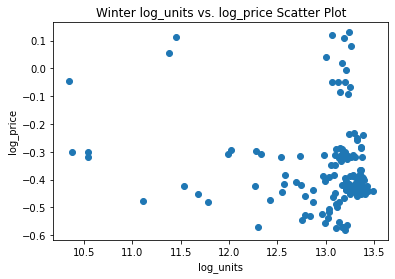

In [47]:
plt.scatter(winter_data["log_units"], winter_data["log_price"])
plt.xlabel("log_units")
plt.ylabel("log_price")
plt.title("Winter log_units vs. log_price Scatter Plot")
plt.show()

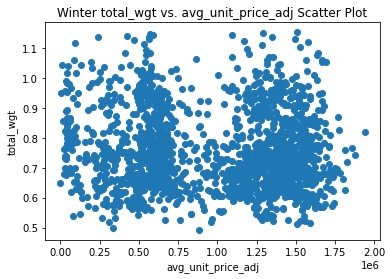

In [48]:
plt.scatter(scope_data["total_wgt"], scope_data["avg_unit_price_adj"])
plt.ylabel("total_wgt")
plt.xlabel("avg_unit_price_adj")
plt.title("Winter total_wgt vs. avg_unit_price_adj Scatter Plot")
plt.show()

In [49]:
west_data = scope_data.loc[scope_data["mkt_lvl"] == "West"]